#1 随机数的曲线拟合-综合比较

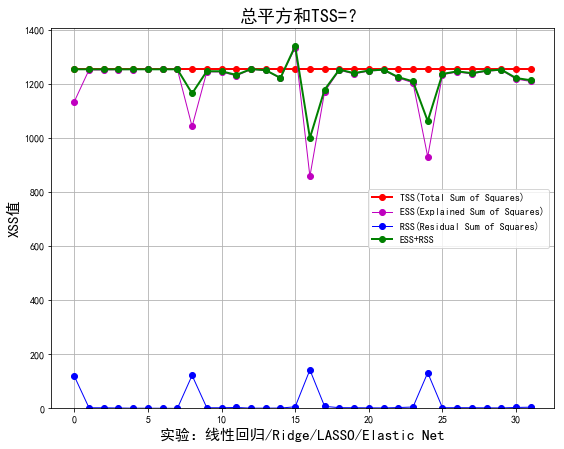

In [3]:
import numpy as np
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.exceptions import ConvergenceWarning
import matplotlib as mpl
import warnings


def xss(y, y_hat):
    y = y.ravel()
    y_hat = y_hat.ravel()
    # Version 1
    tss = ((y - np.average(y)) ** 2).sum()
    rss = ((y_hat - y) ** 2).sum()
    ess = ((y_hat - np.average(y)) ** 2).sum()
    r2 = 1 - rss / tss
    # print 'RSS:', rss, '\t ESS:', ess
    # print 'TSS:', tss, 'RSS + ESS = ', rss + ess
    tss_list.append(tss)
    rss_list.append(rss)
    ess_list.append(ess)
    ess_rss_list.append(rss + ess)
    # Version 2
    # tss = np.var(y)
    # rss = np.average((y_hat - y) ** 2)
    # r2 = 1 - rss / tss
    corr_coef = np.corrcoef(y, y_hat)[0, 1]
    return r2, corr_coef

warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
np.random.seed(0)
np.set_printoptions(linewidth=1000)
N = 9
x = np.linspace(0, 8, N) + np.random.randn(N)
x = np.sort(x)
y = x**2 - 4*x - 3 + np.random.randn(N)
x.shape = -1, 1
y.shape = -1, 1

models = [Pipeline([('poly', PolynomialFeatures()),('linear', LinearRegression(fit_intercept=False))])
    ,
          Pipeline([('poly', PolynomialFeatures()),('linear', RidgeCV(alphas=np.logspace(-3, 2, 50), fit_intercept=False))])
    ,
          Pipeline([('poly', PolynomialFeatures()),('linear', LassoCV(alphas=np.logspace(-3, 2, 50), fit_intercept=False))])
    ,
          Pipeline([('poly', PolynomialFeatures()),('linear', ElasticNetCV(alphas=np.logspace(-3, 2, 50), l1_ratio=[.1, .5, .7, .9, .95, .99, 1],fit_intercept=False))])
          ]
mpl.rcParams['font.sans-serif'] = [u'simHei']
mpl.rcParams['axes.unicode_minus'] = False
np.set_printoptions(suppress=True)

plt.figure(figsize=(18, 12), facecolor='w')
d_pool = np.arange(1, N, 1)  # 阶
m = d_pool.size
clrs = []  # 颜色
for c in np.linspace(16711680, 255, N):
    clrs.append("#{:06X}".format(int(c), 2))
line_width = np.linspace(5, 2, m)
titles = u'线性回归', u'Ridge回归', u'LASSO', u'ElasticNet'
tss_list = []
rss_list = []
ess_list = []
ess_rss_list = []
for t in range(models.__len__()):
    model = models[t]
    for i, d in enumerate(d_pool):
        model.set_params(poly__degree=d)
        model.fit(x, y.ravel())
        lin = model.get_params('linear')['linear']
        output = u'%s：%d阶，系数为：' % (titles[t], d)
        if hasattr(lin, 'alpha_'):
            idx = output.find(u'系数')
            output = output[:idx] + (u'alpha=%.6f，' % lin.alpha_) + output[idx:]
        if hasattr(lin, 'l1_ratio_'):   # 根据交叉验证结果，从输入l1_ratio(list)中选择的最优l1_ratio_(float)
            idx = output.find(u'系数')
            output = output[:idx] + (u'l1_ratio=%.6f，' % lin.l1_ratio_) + output[idx:]
        x_hat = np.linspace(x.min(), x.max(), num=100)
        x_hat.shape = -1, 1
        y_hat = model.predict(x_hat)
        s = model.score(x, y)
        r2, corr_coef = xss(y, model.predict(x))
        
        z = N - 1 if (d == 2) else 0
        label = u'%d阶，$R^2$=%.3f' % (d, s)
        if hasattr(lin, 'l1_ratio_'):
            label += u'，L1 ratio=%.2f' % lin.l1_ratio_

y_max = max(max(tss_list), max(ess_rss_list)) * 1.05
plt.figure(figsize=(9, 7), facecolor='w')
t = np.arange(len(tss_list))
plt.plot(t, tss_list, 'ro-', lw=2, label=u'TSS(Total Sum of Squares)')
plt.plot(t, ess_list, 'mo-', lw=1, label=u'ESS(Explained Sum of Squares)')
plt.plot(t, rss_list, 'bo-', lw=1, label=u'RSS(Residual Sum of Squares)')
plt.plot(t, ess_rss_list, 'go-', lw=2, label=u'ESS+RSS')
plt.ylim((0, y_max))
plt.legend(loc='center right')
plt.xlabel(u'实验：线性回归/Ridge/LASSO/Elastic Net', fontsize=15)
plt.ylabel(u'XSS值', fontsize=15)
plt.title(u'总平方和TSS=？', fontsize=18)
plt.grid(True)
plt.show()